In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
from joblib import Parallel, delayed

# Opérations de traitements


In [2]:
def clean_df(df:pd.DataFrame)->pd.DataFrame:
  df=df.drop(columns=['ancien_code_commune','ancien_nom_commune','ancien_id_parcelle'])
  # Elimination des locaux industriels et commerciaux
  # mutation_commerciale=df[df.code_type_local==4].id_mutation
  # df=df[~df.id_mutation.isin(mutation_commerciale)]
  coltofill=['valeur_fonciere','nombre_pieces_principales','surface_reelle_bati',
            'surface_terrain','lot1_surface_carrez','lot2_surface_carrez',
            'lot3_surface_carrez','lot4_surface_carrez','lot5_surface_carrez',
            'lot1_numero','lot2_numero','lot3_numero','lot4_numero','lot5_numero',
            'adresse_numero','code_postal','numero_volume','longitude','latitude']
  df[coltofill]=df[coltofill].fillna(0)
  df['code_type_local']=df['code_type_local'].fillna(3)
  df['type_local']=df['type_local'].fillna('Dépendance')

  coltofill=['adresse_nom_voie','adresse_code_voie','code_nature_culture',
            'adresse_suffixe','nature_culture','code_nature_culture_speciale',
            'nature_culture_speciale']
  df[coltofill]=df[coltofill].fillna('<EMPTY>')
  return df


# Fonctions de transformations des données en version linéarisée

In [81]:
alt_df_cols=[
             "id_mutation",
             'jour_mutation',
             'mois_mutation',
             'annee_mutation',
             "nature_mutation",
             "valeur_fonciere",
             "adresse_numero",
             "adresse_suffixe",
             'adresse_nom_voie',
             'adresse_code_voie',
             'code_postal',
             'nom_commune',
             'code_departement',
             'id_parcelle',
             'surface_carrez_total',
             'surface_reelle_bati_total',
             'surface_terrain_total',
             'nombre_lots',
             'nombre_maisons',
             'surface_carrez_maisons',
             'surface_reelle_bati_maisons',
             'surface_terrain_maisons',
             'nombre_appartements',
             'surface_carrez_appartements',
             'surface_reelle_bati_appartements',
             'surface_terrain_appartements',
             'nombre_dependances',
             'surface_carrez_dependances',
             'surface_reelle_bati_dependances',
             'surface_terrain_dependances',
             'nombre_pieces_principales',
             'nature_culture',
             'nature_culture_speciale',
             'longitude',
             'latitude',
]

def reduce_get_id(df:pd.DataFrame)->int:
  type_count=df.code_type_local.value_counts()
  if 1 in type_count:
    #Maison
    if type_count[1]==1:
      return df.index.get_loc(df.index[df.code_type_local==1][0])
    else:
      return np.argmax(df.surface_reelle_bati)
  elif 2 in type_count:
    # Appartement
    if type_count[2]==1:
      return df.index.get_loc(df.index[df.code_type_local==2][0])
    else:
      return np.argmax(df.surface_reelle_bati)
  return np.argmax(df.surface_reelle_bati)


def fusion_data(df:pd.DataFrame)->pd.Series:
  iprinc=reduce_get_id(df)
  mut_princ=df.iloc[iprinc]
  values=[]
  # id_mutation
  values.append(mut_princ.id_mutation)
  date=mut_princ.date_mutation.split('-')
  # jour_mutation
  values.append(date[2])
  # mois_mutation
  values.append(date[1])
  # annee_mutation
  values.append(date[0])
  # nature_mutation
  values.append(mut_princ.nature_mutation)
  # valeur_fonciere
  values.append(mut_princ.valeur_fonciere)
  # adresse_numero
  values.append(mut_princ.adresse_numero)
  # adresse_suffixe
  values.append(mut_princ.adresse_suffixe)
  # adresse_nom_voie
  values.append(mut_princ.adresse_nom_voie)
  # adresse_code_voie
  values.append(mut_princ.adresse_code_voie)
  # code_postal
  values.append(mut_princ.code_postal)
  # nom_commune
  values.append(mut_princ.nom_commune)
  # code_departement
  values.append(mut_princ.code_departement)
  # id_parcelle
  values.append(mut_princ.id_parcelle)
  # surface_carrez_total
  cols_carrez=['lot1_surface_carrez','lot2_surface_carrez','lot3_surface_carrez','lot4_surface_carrez','lot5_surface_carrez']
  values.append(df[cols_carrez].sum().sum())
  # surface_reelle_bati_total
  values.append(df.surface_reelle_bati.sum())
  # surface_terrain_total
  values.append(df.surface_terrain.sum())
  # nombre_lots
  values.append(df.nombre_lots.sum())
  # nombre_maisons
  # surface_carrez_maisons
  # surface_reelle_bati_maisons
  # surface_terrain_maisons
  def surface_divide(indice:int):
    # nombre_local
    type_locaux=df.code_type_local.value_counts()
    values.append(0 if indice not in type_locaux else type_locaux[indice])
    # surface_carrez_local
    values.append(df[df.code_type_local==indice][cols_carrez].sum().sum())
    # surface_reelle_bati_local
    values.append(df[df.code_type_local==indice].surface_reelle_bati.sum().sum())
    # surface_terrain_local
    values.append(df[df.code_type_local==indice].surface_terrain.sum().sum())
  surface_divide(1)
  # nombre_appartements
  # surface_carrez_appartements
  # surface_reelle_bati_appartements
  # surface_terrain_appartements
  surface_divide(2)
  # nombre_dependences
  # surface_carrez_dependences
  # surface_reelle_bati_dependences
  # surface_terrain_dependences
  surface_divide(3)
  # nombre_pieces_principales
  values.append(df.nombre_pieces_principales.sum())
  # nature_culture
  values.append(mut_princ.nature_culture)
  # nature_culture_speciale
  values.append(mut_princ.nature_culture_speciale)
  # longitude
  values.append(mut_princ.longitude)
  # latitude
  values.append(mut_princ.latitude)
  return pd.Series({ k:v for k,v in zip(alt_df_cols,values)}, index=alt_df_cols)

def applyParallel(dfGrouped, func):
    retLst = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(func)(group) for _, group in dfGrouped)
    return pd.DataFrame(retLst,columns=alt_df_cols)


# Traitements des CSV

In [190]:
for i,annee in enumerate(range(2020,2022)):
  if i ==0:
    df=pd.read_csv(f"original/{annee}.csv",encoding='utf8')
    df=clean_df(df)
  else:
    df2=pd.read_csv(f"original/{annee}.csv",encoding='utf8')
    df2=clean_df(df2)
    df=pd.concat([df,df2])
    
  print(annee)
  # new_df=applyParallel(df.groupby("id_mutation"), fusion_data)
  # new_df=df.groupby("id_mutation").apply(fusion_data)
  # new_df=new_df.set_index("id_mutation")
  # new_df.to_csv(f'clean_data/{annee}_cleaned.csv',encoding='utf8')
  

2020


C:\Users\Romain\AppData\Local\pypoetry\Cache\virtualenvs\dvf-rJvO6ggo-py3.9\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (10,12,17,18,20,22,24,35,36) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


2021


In [99]:
df.columns

Index(['id_mutation', 'date_mutation', 'numero_disposition', 'nature_mutation',
       'valeur_fonciere', 'adresse_numero', 'adresse_suffixe',
       'adresse_nom_voie', 'adresse_code_voie', 'code_postal', 'code_commune',
       'nom_commune', 'code_departement', 'id_parcelle', 'numero_volume',
       'lot1_numero', 'lot1_surface_carrez', 'lot2_numero',
       'lot2_surface_carrez', 'lot3_numero', 'lot3_surface_carrez',
       'lot4_numero', 'lot4_surface_carrez', 'lot5_numero',
       'lot5_surface_carrez', 'nombre_lots', 'code_type_local', 'type_local',
       'surface_reelle_bati', 'nombre_pieces_principales',
       'code_nature_culture', 'nature_culture', 'code_nature_culture_speciale',
       'nature_culture_speciale', 'surface_terrain', 'longitude', 'latitude'],
      dtype='object')

In [2]:
def load_data(annee:int,derniere_annee=2023)->pd.DataFrame:
  df=pd.read_pickle(f"clean_data/{annee}_cleaned.pkl.bz2",compression="bz2")
  for annee in range(annee+1,derniere_annee):
    print(annee)
    df=pd.concat([df,pd.read_pickle(f"clean_data/{annee}_cleaned.pkl.bz2",compression="bz2")],ignore_index=True,axis=0)

  df=df.sample(frac=1,random_state=42)
  return df
init_df=load_data(2014)

2015
2016
2017
2018
2019
2020
2021
2022


In [3]:
prev_taille=len(init_df)
df=init_df[(init_df.nombre_appartements+init_df.nombre_maisons==1) & (init_df.nombre_dependances<=3) & (init_df.nombre_lots==1)]
taille = len(df)
while taille!=prev_taille:
    print(taille, prev_taille)
    prev_taille=taille
    df=df[df.valeur_fonciere <df.valeur_fonciere.std()*50+df.valeur_fonciere.mean()]
    taille=len(df)

805322 11655233
805307 805322
805305 805307


In [4]:
df.describe()

,valeur_fonciere,adresse_numero,code_postal,surface_carrez_total,surface_reelle_bati_total,surface_terrain_total,nombre_lots,nombre_maisons,surface_carrez_maisons,surface_reelle_bati_maisons,...,surface_carrez_appartements,surface_reelle_bati_appartements,surface_terrain_appartements,nombre_dependances,surface_carrez_dependances,surface_reelle_bati_dependances,surface_terrain_dependances,nombre_pieces_principales,longitude,latitude
count,8.053050e+05,805305.000000,805305.000000,805305.000000,805305.000000,805305.000000,805305.0,805305.000000,805305.000000,805305.000000,...,805305.000000,805305.000000,805305.000000,805305.000000,805305.000000,805305.000000,805305.000000,805305.000000,805305.000000,805305.000000
mean,1.768478e+05,586.289131,53373.594369,35.252417,52.212470,16.426710,1.0,0.157785,8.679343,13.652552,...,26.550893,38.559865,0.211632,0.042317,0.022181,0.000053,8.238567,2.392774,2.549609,45.255594
std,1.827943e+05,1919.257189,29541.880381,51.018113,33.329252,533.962738,0.0,0.364539,35.825765,34.599823,...,42.170269,31.089630,12.448664,0.255518,1.866269,0.027725,527.682092,1.332159,7.943804,7.459247
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-63.115060,-21.384136
25%,7.800000e+04,8.000000,30100.000000,0.000000,28.000000,0.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.900666,43.620513
50%,1.300000e+05,23.000000,60100.000000,28.100000,44.000000,0.000000,1.0,0.000000,0.000000,0.000000,...,20.870000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.477167,45.836960
75%,2.164500e+05,71.000000,76000.000000,54.760000,70.000000,0.000000,1.0,0.000000,0.000000,0.000000,...,43.040000,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,5.356618,48.847426
max,9.140000e+06,9999.000000,97490.000000,9500.000000,3640.000000,429208.000000,1.0,1.000000,9500.000000,1586.000000,...,8840.000000,3640.000000,3345.000000,3.000000,1000.000000,15.000000,429208.000000,89.000000,55.720651,51.081805


<Axes: xlabel='valeur_fonciere', ylabel='Count'>

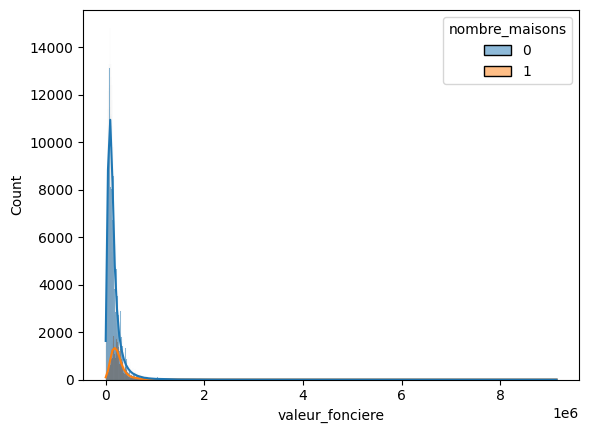

In [5]:
sns.histplot(df,x="valeur_fonciere",hue="nombre_maisons",kde=True)

In [6]:
df.iloc[df.valeur_fonciere.argmax()]

jour_mutation                                            22
mois_mutation                                             1
annee_mutation                                         2021
nature_mutation                                       Vente
valeur_fonciere                                   9140000.0
adresse_numero                                          5.0
adresse_suffixe                                     <EMPTY>
adresse_nom_voie                             QUAI MALAQUAIS
adresse_code_voie                                      5943
code_postal                                         75006.0
nom_commune                         Paris 6e Arrondissement
code_departement                                         75
id_parcelle                                  75106000BM0046
surface_carrez_total                                 254.04
surface_reelle_bati_total                             257.0
surface_terrain_total                                   0.0
nombre_lots                             